# Sport Analytics final project: The quest for the right pass: quantify soccer player’s decision making

Ali Bakkoury  
Hugo Artigas

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import shap
from statsbombpy import sb
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

pd.set_option('display.max_columns', 100)

In [2]:
sb.competitions().query("competition_name == 'La Liga'").sort_values("season_name", ascending=False).head(3)

credentials were not supplied. open data access only


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
20,11,90,Spain,La Liga,male,False,False,2020/2021,2022-02-11T14:56:09.076,2022-08-16T21:50:36.812060,2022-08-16T21:50:36.812060,2022-02-11T14:56:09.076
21,11,42,Spain,La Liga,male,False,False,2019/2020,2022-07-15T23:27:24.260122,2021-06-13T16:17:31.694,None,2022-07-15T23:27:24.260122
22,11,4,Spain,La Liga,male,False,False,2018/2019,2022-08-30T23:25:57.118855,2021-07-09T14:53:22.103024,None,2022-08-30T23:25:57.118855


In [3]:
LALIGA_ID = 11
SEASON_2021_ID = 90 

In [4]:
all_matches = sb.matches(competition_id=LALIGA_ID, season_id=SEASON_2021_ID)
match_passes = pd.concat(
               [sb.events(match_id=match_id, split=True, flatten_attrs=False)["passes"]
               .assign(match_date = match_date)
               .assign(match_week = match_week) 
               .assign(home_team = home_team)
               .assign(away_team = away_team)
               for match_id, match_week, home_team, away_team, match_date 
               in zip(
                    all_matches["match_id"], all_matches["match_week"],
                    all_matches["home_team"], all_matches["away_team"],
                    all_matches["match_date"]
                     )
                ]
               )

credentials were not supplied. open data access only


In [5]:
print(f"Dataset with {len(match_passes):,} passes")
print(list(match_passes.columns))

Dataset with 40,337 passes
['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'pass', 'match_id', 'possession_team_id', 'player_id', 'under_pressure', 'counterpress', 'off_camera', 'match_date', 'match_week', 'home_team', 'away_team', 'out']


In [6]:
match_passes.head(3)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,player,position,location,duration,related_events,pass,match_id,possession_team_id,player_id,under_pressure,counterpress,off_camera,match_date,match_week,home_team,away_team,out
0,3c824f32-fcd1-4191-b824-26bb32d9bd6c,5,1,00:00:00.992,0,0,Pass,2,Real Betis,From Kick Off,Real Betis,Borja Iglesias Quintas,Center Forward,"[60.0, 40.0]",1.137457,[953b857b-55b9-4f14-974c-63e2929e6de1],"{'recipient': {'id': 2948, 'name': 'Nabil Feki...",3773631,218,11391,NaN,NaN,NaN,2021-02-07,22,Real Betis,Barcelona,NaN
1,723a939c-cc2f-49a9-8b95-20373c926cc6,7,1,00:00:02.130,0,2,Pass,2,Real Betis,From Kick Off,Real Betis,Nabil Fekir,Center Attacking Midfield,"[56.7, 41.1]",1.100128,[59962ded-d646-4f9c-bf6d-ebba06ef28d3],"{'recipient': {'id': 42282, 'name': 'Paul Edga...",3773631,218,2948,NaN,NaN,NaN,2021-02-07,22,Real Betis,Barcelona,NaN
2,90973a59-4f2e-436c-a982-45a6fd35280d,10,1,00:00:04.345,0,4,Pass,2,Real Betis,From Kick Off,Real Betis,Paul Edgar Akouokou,Right Defensive Midfield,"[43.5, 37.6]",1.746256,[f719fb9a-1271-49c5-9051-3c7e7154e0e9],"{'recipient': {'id': 6752, 'name': 'Víctor Ruí...",3773631,218,42282,NaN,NaN,NaN,2021-02-07,22,Real Betis,Barcelona,NaN


In [7]:
def extract_pass_features(df):
    
    df["outcome"] = df["pass"].apply(lambda x : x.get("outcome", {}).get("name"))
    df["recipient_id"] = df["pass"].apply(lambda x : x.get("recipient", {}).get("id"))
    df["length"] = df["pass"].apply(lambda x : x.get("length"))
    df["angle"] = df["pass"].apply(lambda x : x.get("angle"))
    df["height"] = df["pass"].apply(lambda x : x.get("height", {}).get("name"))
    df["body_part"] = df["pass"].apply(lambda x : x.get("body_part", {}).get("name"))
    df["end_location"] = df["pass"].apply(lambda x : x.get("end_location"))
    df["home"] = df["possession_team"] == df["home_team"]
    df["opponent"] = df.apply(lambda x : x["home_team"] if x["home_team"] != x["possession_team"] else x["away_team"], axis=1)
    df["n_related_events"] = df.related_events.apply(lambda x : len(x) if type(x) == list else None).fillna(0)

    return df

def manage_nas(df):
    for column in ["under_pressure", "counterpress", "off_camera"]:
        if column not in df.columns: continue
        df[column] = df[column].fillna(False)
    df["outcome"] = df["outcome"].fillna("Completed")
    return df

def zone(x,N,l):
    if x!=l :
        step = l/N
        return int(x//step)
    else: return int(N-1)

def field_partition(df):
    n = 50
    m = 32
    df['field_zone_x'] = df['location'].apply(lambda x: zone(x[0],n,120))
    df['field_zone_y'] = df['location'].apply(lambda x: zone(x[1],m,80))
    df['end_field_zone_x'] = df['end_location'].apply(lambda x: zone(x[0],n,120))
    df['end_field_zone_y'] = df['end_location'].apply(lambda x: zone(x[1],m,80))
    return df

In [8]:
match_passes = extract_pass_features(match_passes)
match_passes = manage_nas(match_passes)
match_passes = field_partition(match_passes)
match_passes = match_passes[(match_passes['outcome'] == 'Completed') | (match_passes['outcome']== 'Incomplete') | (match_passes['outcome']== 'Out') ]

# Number of passes attempted by Barcelona vs opponents

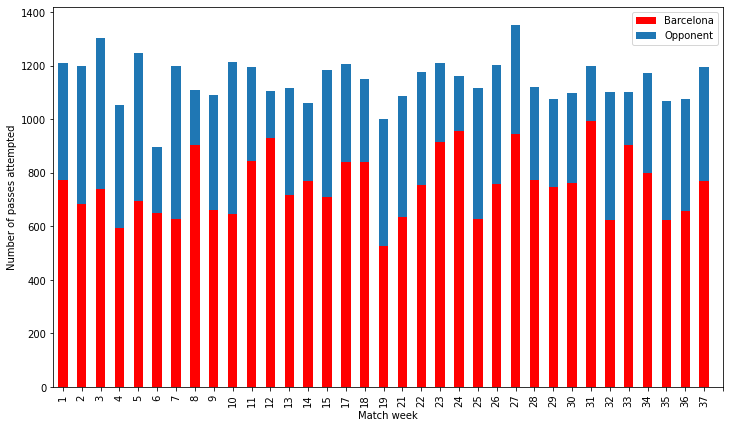

In [9]:
match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), color = "red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), bottom = match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index(), label="Opponent")
plt.xlabel("Match week")
plt.ylabel("Number of passes attempted")
plt.xticks(range(0,36))
plt.legend();

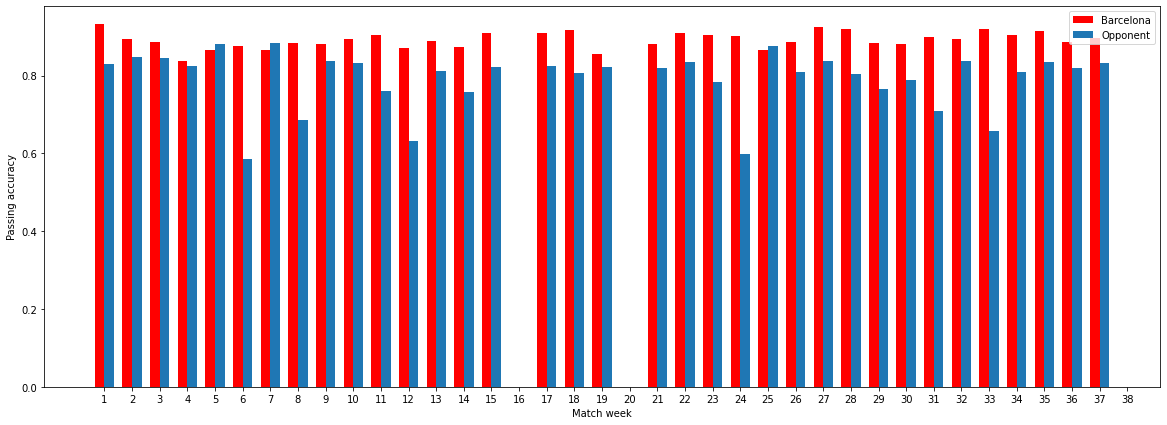

In [10]:
plt.figure(figsize=(20,7))
barcelona = match_passes.query("possession_team == 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
plt.bar(barcelona.index, barcelona.values, width=0.35, color="red", label ="Barcelona")

opponents = match_passes.query("possession_team != 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
opponents.index = (opponents.index + 0.35).astype(float)
plt.bar(opponents.index, opponents.values, width=0.35, label="Opponent")
plt.xticks([x+0.35/2 for x in range(1, 39)], range(1, 39));
plt.xlabel("Match week")
plt.ylabel("Passing accuracy")
plt.legend(loc="upper right");

In [11]:
match_passes.outcome.value_counts(normalize=True)

Completed     0.865102
Incomplete    0.123161
Out           0.011737
Name: outcome, dtype: float64

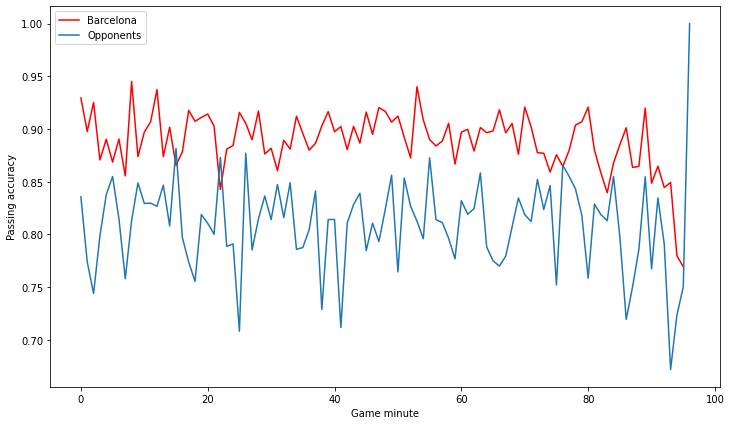

In [12]:
plt.figure(figsize=(12,7))
match_passes.query("possession_team == 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(color="red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(label="Opponents")
plt.xlabel("Game minute")
plt.ylabel("Passing accuracy")
plt.legend();

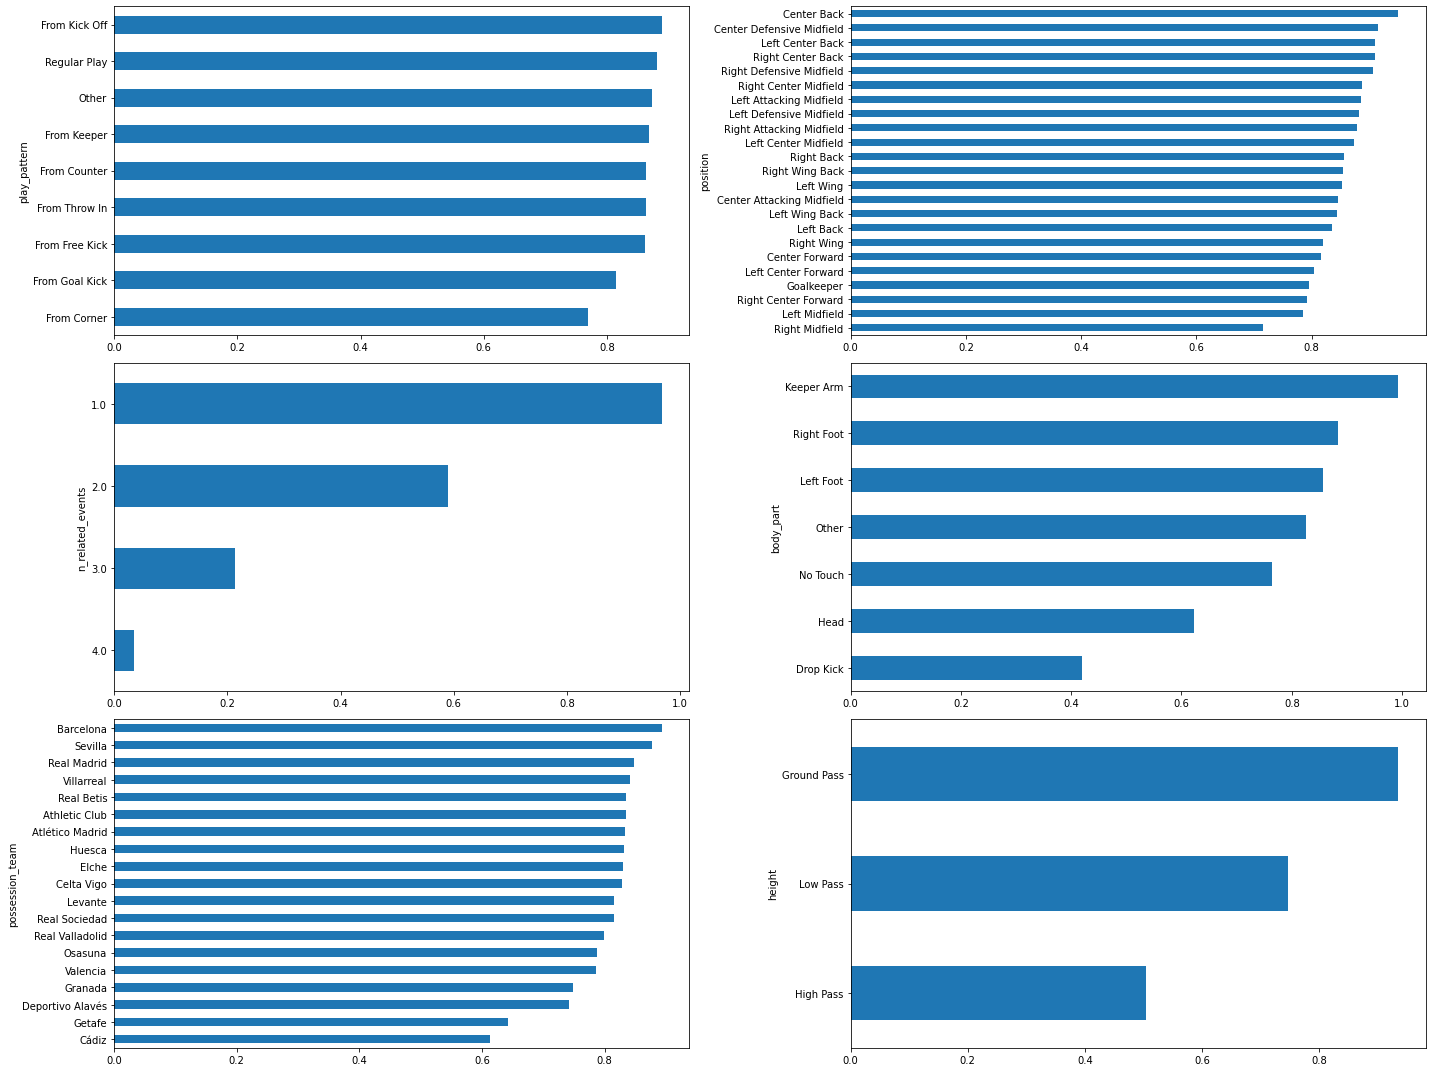

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
for i, column in enumerate(["play_pattern", "position", "n_related_events", "body_part", "possession_team", "height"], 1):
    ax = plt.subplot(3, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.barh(ax=ax)

fig.tight_layout()

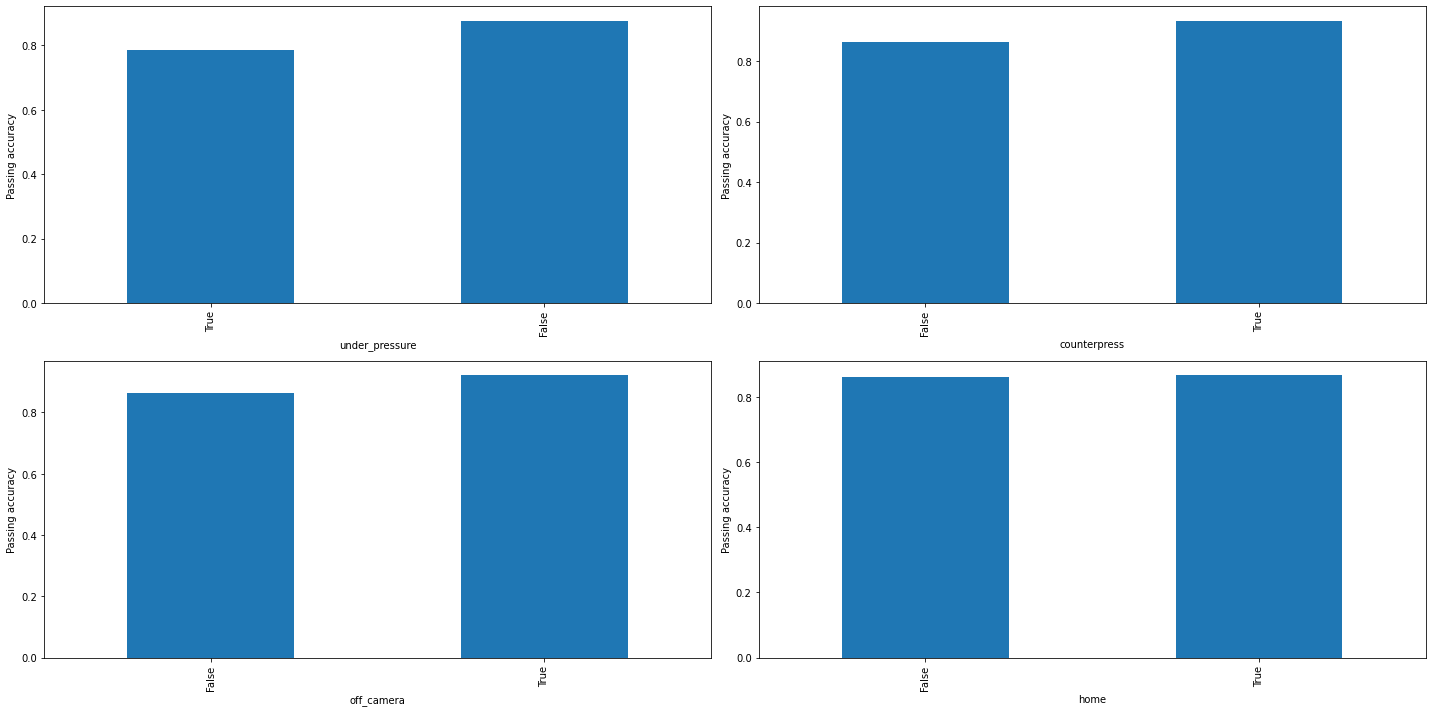

In [14]:
fig, axes = plt.subplots(2,2, figsize=(20, 10))

for i, column in enumerate(["under_pressure", "counterpress", "off_camera", "home"], 1):
    ax = plt.subplot(2, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.bar(ax=ax)
    ax.set_ylabel("Passing accuracy")

fig.tight_layout()

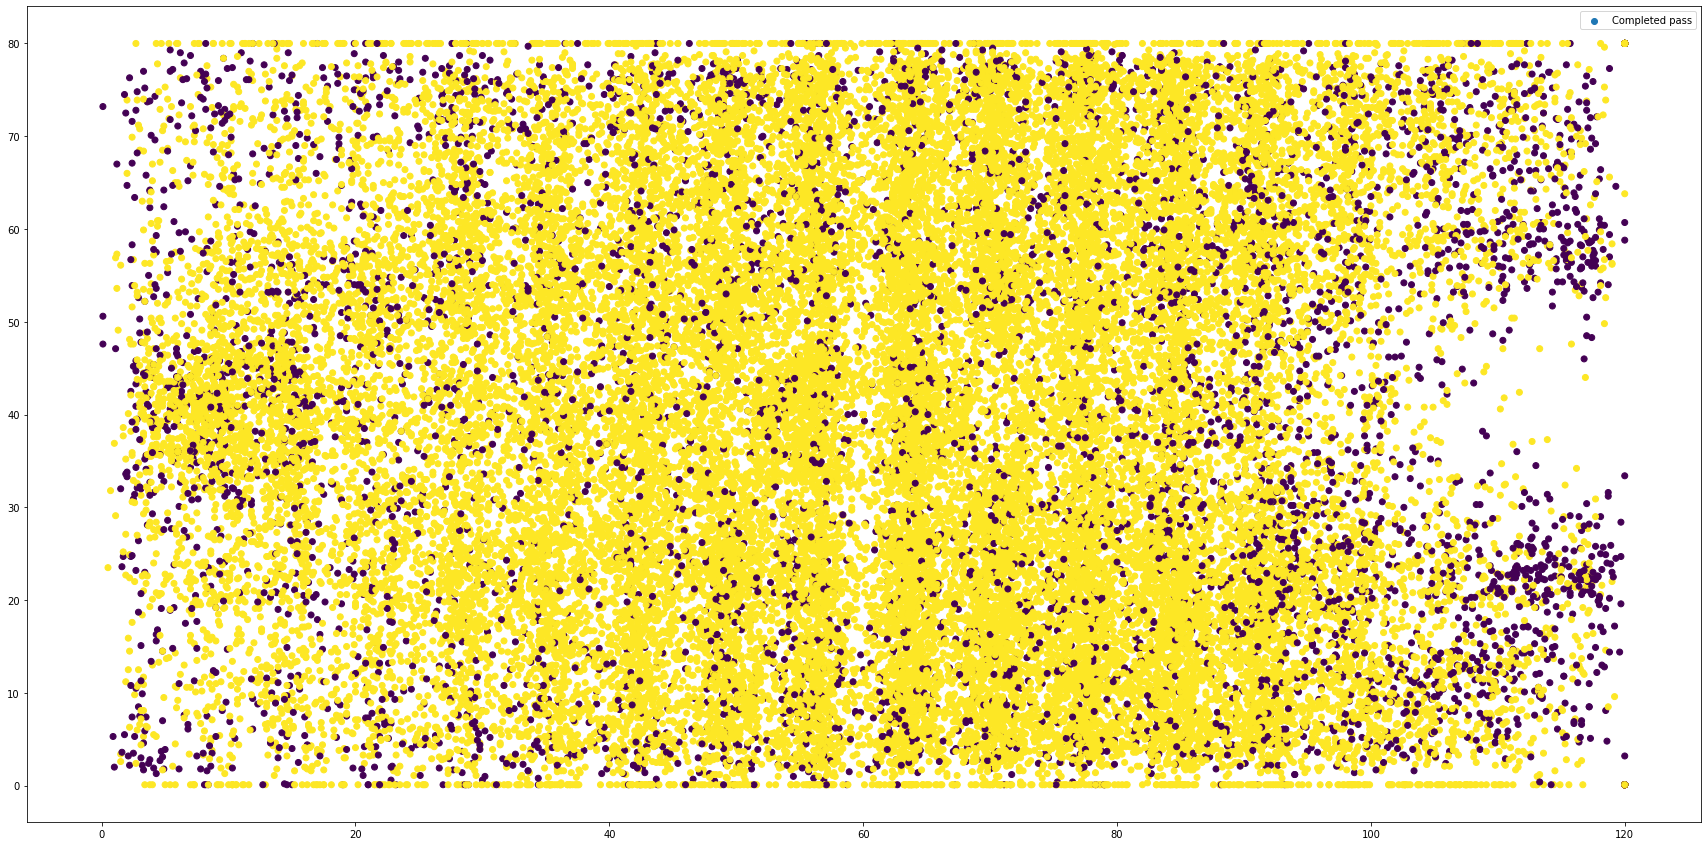

In [15]:
plt.figure(figsize=(30,15))
locations = match_passes["location"].apply(pd.Series)
locations.columns = ["x", "y"]
plt.scatter(locations["x"], locations["y"], c = match_passes["outcome"] == "Completed")
plt.legend({"Completed pass"});

In [16]:
match_passes.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'pass',
       'match_id', 'possession_team_id', 'player_id', 'under_pressure',
       'counterpress', 'off_camera', 'match_date', 'match_week', 'home_team',
       'away_team', 'out', 'outcome', 'recipient_id', 'length', 'angle',
       'height', 'body_part', 'end_location', 'home', 'opponent',
       'n_related_events', 'field_zone_x', 'field_zone_y', 'end_field_zone_x',
       'end_field_zone_y'],
      dtype='object')

## Modeling

In [17]:
RANDOM_STATE = 42

In [18]:
TARGET = "outcome"
FEATURES = ["minute", "play_pattern", "location", "counterpress", "under_pressure", "off_camera", "match_week", "length", "angle", "height", "body_part", "end_location"]
CATEGORICAL_COLUMNS = ["play_pattern", "height", "body_part"]

In [19]:
def prepare_train_test_data(match_passes, features=FEATURES, categorical_columns=CATEGORICAL_COLUMNS, split=True):
    match_passes = match_passes.sort_values("match_week")
    X = match_passes[features].reset_index(drop=True)
    y = (match_passes[TARGET] == "Completed").astype(int).reset_index(drop=True)
    
    if "location" in features:
        X["location_x"], X["location_y"] = X["location"].apply(pd.Series).T.values
        X["end_location_x"], X["end_location_y"] = X["end_location"].apply(pd.Series).T.values
        X = X.drop(["location", "end_location"], axis=1)

    for c in ["counterpress", "under_pressure", "off_camera"]:
        if c not in X.columns: continue
        X[c] = X[c].astype(int)    
    
    encoder = OneHotEncoder()
    encoded_cat = pd.DataFrame(encoder.fit_transform(X[categorical_columns]).toarray(), columns = encoder.get_feature_names_out(input_features=categorical_columns)).astype(int)
    X = pd.concat([X, encoded_cat], axis=1).drop(categorical_columns, axis=1)
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=RANDOM_STATE)
        return  X_train, X_test, y_train, y_test
    else: 
        return X, y



def build_and_evaluate_model(data, model_params):
    X_train, X_test, y_train, y_test = data
    model = xgb.XGBClassifier(**model_params)
    model.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose=50
            )
    print("AUC score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
    print(confusion_matrix(y_test, model.predict(X_test)))
    return model, pd.DataFrame(model.feature_importances_, index=X_train.columns, columns =["importance"]).sort_values("importance", ascending= False).T

In [20]:
scale_pos_weight = np.sqrt(match_passes["outcome"].value_counts().loc["Incomplete"]/match_passes["outcome"].value_counts().loc["Completed"])
model_params = {"n_estimators" : 700, "early_stopping_rounds":50, "learning_rate":0.05, "max_depth" : 5, "eval_metric":"auc", "scale_pos_weight":scale_pos_weight, "random_state": RANDOM_STATE}

In [21]:
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes)
model, importances = build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[23:16:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85723	validation_1-auc:0.83499
[50]	validation_0-auc:0.91351	validation_1-auc:0.89847
[100]	validation_0-auc:0.92717	validation_1-auc:0.90769
[150]	validation_0-auc:0.93260	validation_1-auc:0.90954
[200]	validation_0-auc:0.93680	validation_1-auc:0.90975
[250]	validation_0-auc:0.94006	validation_1-auc:0.91030
[300]	validation_0-auc:0.94263	validation_1-auc:0.91082
[350]	validation_0-auc:0.94495	validation_1-auc:0.91088
[400]	validation_0-auc:0.94745	validation_1-auc:0.91060
[450]	validation_0-auc:0.94992	validation_1-auc:0.91069
[500]	validation_0-auc:0.95240	validation_1-auc:0.91063
[550]	validation

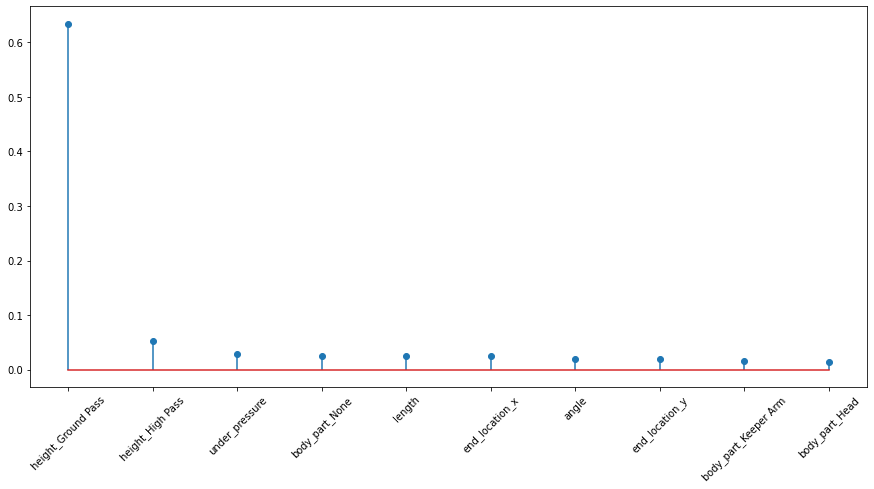

In [22]:
plt.figure(figsize=(15,7))
plt.stem(importances.T.index[:10], importances.T.values[:10])
plt.xticks(importances.T.index[:10], rotation=45);

### Pass accuracy feature

In [23]:
players_pass_accuracy = {}
for match_date in match_passes["match_date"].unique():
    df = match_passes[["match_date", "player_id", "outcome"]].query("match_date < @match_date")
    if len(df) == 0: continue
    pass_accuracy = df.sort_values("match_date").groupby("player_id").outcome.value_counts(normalize=True).loc[:, "Completed"]
    for player in pass_accuracy.to_dict():
        players_pass_accuracy[player] = players_pass_accuracy.get(player, {})
        players_pass_accuracy[player].update({match_date: pass_accuracy[player]})

In [24]:
match_passes["pass_accuracy"] = match_passes.apply(lambda x: players_pass_accuracy.get(x["player_id"], {}).get(x["match_date"]), axis = 1)

In [25]:
new_features_pa = FEATURES + ["pass_accuracy"]
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_pa)
model,feat_import = build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)
feat_import

[23:17:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85734	validation_1-auc:0.83494
[50]	validation_0-auc:0.91628	validation_1-auc:0.90111
[100]	validation_0-auc:0.92952	validation_1-auc:0.90942
[150]	validation_0-auc:0.93570	validation_1-auc:0.91179
[200]	validation_0-auc:0.93988	validation_1-auc:0.91205
[250]	validation_0-auc:0.94319	validation_1-auc:0.91251
[300]	validation_0-auc:0.94575	validation_1-auc:0.91265
[350]	validation_0-auc:0.94845	validation_1-auc:0.91281
[400]	validation_0-auc:0.95072	validation_1-auc:0.91274
[450]	validation_0-auc:0.95288	validation_1-auc:0.91273
[500]	validation_0-auc:0.95513	validation_1-auc:0.91221
[550]	validation

,height_Ground Pass,height_High Pass,under_pressure,length,end_location_x,body_part_None,angle,end_location_y,body_part_Head,body_part_Keeper Arm,play_pattern_Regular Play,pass_accuracy,play_pattern_From Throw In,location_y,off_camera,play_pattern_From Counter,location_x,body_part_Left Foot,play_pattern_From Corner,play_pattern_From Goal Kick,counterpress,body_part_Other,play_pattern_From Kick Off,play_pattern_From Free Kick,body_part_No Touch,match_week,height_Low Pass,body_part_Right Foot,minute,play_pattern_From Keeper,body_part_Drop Kick,play_pattern_Other
importance,0.584303,0.058458,0.035703,0.030086,0.027697,0.02335,0.022886,0.021246,0.016827,0.015155,0.0138,0.010972,0.010474,0.010144,0.010106,0.010074,0.009651,0.009393,0.008492,0.007998,0.007619,0.007254,0.007183,0.006878,0.006071,0.005853,0.005298,0.005278,0.005257,0.004531,0.001965,0.0


### Pass accuracy last n games

In [26]:
N = 5

players_pass_accuracy_last_n = {}
for match_date in match_passes["match_date"].unique():
    df = match_passes[["match_date", "player_id", "outcome"]].query("match_date < @match_date")
    df["match_rank"] = df["match_date"].rank(method="dense")
    df["match_rank"] = df["match_rank"].max() - df["match_rank"] + 1
    df = df.query("match_rank <= @N")
    if len(df) == 0: continue
    pass_accuracy = df.sort_values("match_date").groupby("player_id").outcome.value_counts(normalize=True).loc[:, "Completed"]
    for player in pass_accuracy.to_dict():
        players_pass_accuracy_last_n[player] = players_pass_accuracy_last_n.get(player, {})
        players_pass_accuracy_last_n[player].update({match_date: pass_accuracy[player]})

In [27]:
match_passes["pass_accuracy_last_5"] = match_passes.apply(lambda x: players_pass_accuracy_last_n.get(x["player_id"], {}).get(x["match_date"]), axis = 1)

In [28]:
new_features_pa5 = FEATURES + ["pass_accuracy_last_5"]
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_pa5, categorical_columns=CATEGORICAL_COLUMNS)
model,feat_import = build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[23:17:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85734	validation_1-auc:0.83467
[50]	validation_0-auc:0.91564	validation_1-auc:0.90082
[100]	validation_0-auc:0.92881	validation_1-auc:0.90855
[150]	validation_0-auc:0.93483	validation_1-auc:0.91124
[200]	validation_0-auc:0.93898	validation_1-auc:0.91214
[250]	validation_0-auc:0.94260	validation_1-auc:0.91255
[300]	validation_0-auc:0.94516	validation_1-auc:0.91286
[350]	validation_0-auc:0.94766	validation_1-auc:0.91295
[400]	validation_0-auc:0.95034	validation_1-auc:0.91300
[450]	validation_0-auc:0.95264	validation_1-auc:0.91287
[500]	validation_0-auc:0.95511	validation_1-auc:0.91298
[550]	validation

### Match pass accuracy feature

In [29]:
match_passes["completed"] = match_passes["outcome"] == "Completed"
index = match_passes.groupby(["player_id", "match_week", "minute"]).agg({"completed": ["sum", "count"]}).index
passes_completed = (match_passes.groupby(["player_id", "match_week", "minute"]).agg({"completed": ["sum", "count"]})).reset_index()["completed"].set_index(index).groupby(["player_id", "match_week"]).cumsum()

In [30]:
match_pass_accuracy = pd.DataFrame((passes_completed["sum"]/passes_completed["count"]).shift(1).rename("match_pass_accuracy"))
match_passes = match_passes.merge(match_pass_accuracy, right_index=True, left_on=["player_id", "match_week", "minute"])

In [31]:
new_features_mpa = new_features_pa + ["match_pass_accuracy"]
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_mpa)
model_final, feat_import = build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)
feat_import

[23:18:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85736	validation_1-auc:0.83470
[50]	validation_0-auc:0.91710	validation_1-auc:0.90093
[100]	validation_0-auc:0.93049	validation_1-auc:0.90893
[150]	validation_0-auc:0.93659	validation_1-auc:0.91233
[200]	validation_0-auc:0.94084	validation_1-auc:0.91241
[250]	validation_0-auc:0.94414	validation_1-auc:0.91271
[300]	validation_0-auc:0.94708	validation_1-auc:0.91366
[350]	validation_0-auc:0.94977	validation_1-auc:0.91354
[400]	validation_0-auc:0.95231	validation_1-auc:0.91391
[450]	validation_0-auc:0.95542	validation_1-auc:0.91360
[500]	validation_0-auc:0.95761	validation_1-auc:0.91329
[550]	validation

,height_Ground Pass,height_High Pass,under_pressure,length,end_location_x,body_part_None,angle,end_location_y,body_part_Head,body_part_Keeper Arm,play_pattern_Regular Play,play_pattern_From Throw In,pass_accuracy,play_pattern_From Counter,location_y,location_x,play_pattern_From Corner,off_camera,match_pass_accuracy,play_pattern_From Free Kick,counterpress,body_part_Left Foot,body_part_Other,play_pattern_From Kick Off,height_Low Pass,match_week,play_pattern_From Goal Kick,body_part_Right Foot,play_pattern_From Keeper,minute,body_part_No Touch,body_part_Drop Kick,play_pattern_Other
importance,0.575184,0.057534,0.033045,0.029876,0.027641,0.026375,0.023405,0.020312,0.016218,0.016186,0.015421,0.012147,0.010758,0.010596,0.010223,0.009984,0.009925,0.009098,0.008189,0.007875,0.007346,0.00717,0.006783,0.006611,0.006295,0.006067,0.006067,0.005734,0.005493,0.005257,0.004637,0.002548,0.0


<AxesSubplot:>

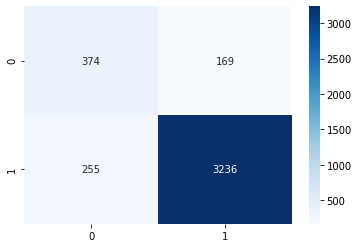

In [32]:
import seaborn as sns
sns.heatmap([[ 374,  169],
            [255, 3236]], cmap="Blues",annot =True, fmt=".0f")

### Running model only on ground passes

In [33]:
match_ground_passes = match_passes.query("height == 'Ground Pass'")
new_features_ground = list(set(new_features_pa) - set(["height"]))
cat_cols_ground = list(set(CATEGORICAL_COLUMNS) - set(["height"]))
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_ground_passes, features=new_features_ground, categorical_columns=cat_cols_ground)
model_params["scale_pos_weight"] = np.sqrt((1-y_train).sum()/y_train.sum()) #Updating scale_pos_weight as the target variable distribution changed
build_and_evaluate_model((X_train, X_test, y_train, y_test), model_params)

[23:18:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79464	validation_1-auc:0.74681
[50]	validation_0-auc:0.90497	validation_1-auc:0.86553
[100]	validation_0-auc:0.92054	validation_1-auc:0.87069
[150]	validation_0-auc:0.93032	validation_1-auc:0.87151
[200]	validation_0-auc:0.93676	validation_1-auc:0.87147
[250]	validation_0-auc:0.94359	validation_1-auc:0.86984
[300]	validation_0-auc:0.94939	validation_1-auc:0.86986
[350]	validation_0-auc:0.95365	validation_1-auc:0.86999
[400]	validation_0-auc:0.95849	validation_1-auc:0.87085
[450]	validation_0-auc:0.96288	validation_1-auc:0.87116
[500]	validation_0-auc:0.96726	validation_1-auc:0.87034
[550]	validation

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
               eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.05, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=700, n_jobs=0,
               num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=0.2634388552497654, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
             under_pressure    length  end_location_x  end_location_y  \
 importance        0.121662  0.108292          0.0939        0.059539   
 
             off_camera     angle  play_pattern_From Corner  \
 importance    0.059308  0.056677                   0.04752   
 
             body_part_Right Foot  pass_accuracy  location_x  

### SHAP Values

In [34]:
model_params = {"n_estimators" : 700, "learning_rate":0.05, "max_depth" : 5, "eval_metric":"auc", "scale_pos_weight":scale_pos_weight, "random_state": RANDOM_STATE}

In [35]:
X_train, X_test, y_train, y_test = prepare_train_test_data(match_passes=match_passes, features=new_features_mpa)
model = xgb.XGBClassifier(**model_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.37731475352978766, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

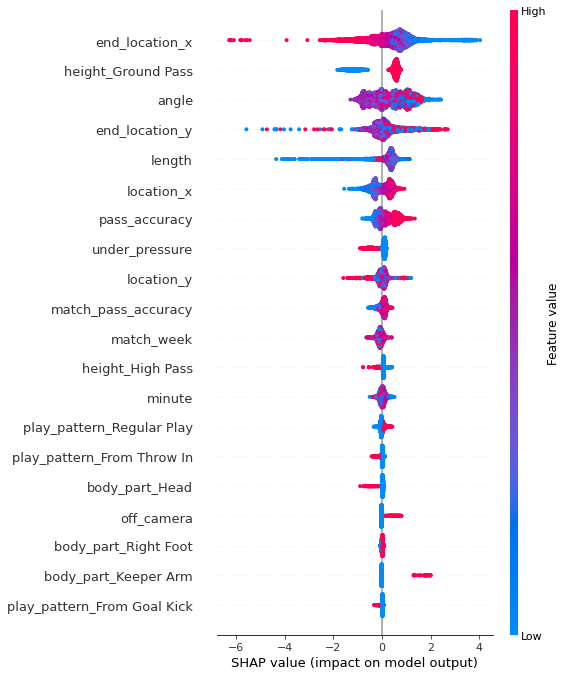

In [37]:
shap.summary_plot(shap_values, X_test)

### Testing model on different competition data

In [38]:
CHAMPIONS_LEAGUE_ID = 16
SEASON_1819_ID = 4

In [39]:
TARGET = "outcome"
FEATURES = ["minute", "play_pattern", "location", "under_pressure", "off_camera", "match_week", "length", "angle", "height", "body_part", "end_location"]
CATEGORICAL_COLUMNS = ["play_pattern", "height", "body_part"]

In [40]:
all_matches_test = sb.matches(competition_id=CHAMPIONS_LEAGUE_ID, season_id=SEASON_1819_ID)
match_passes_test = pd.concat(
               [sb.events(match_id=match_id, split=True, flatten_attrs=False)["passes"]
               .assign(match_date = match_date)
               .assign(match_week = match_week) 
               .assign(home_team = home_team)
               .assign(away_team = away_team)
               for match_id, match_week, home_team, away_team, match_date 
               in zip(
                    all_matches_test["match_id"], all_matches_test["match_week"],
                    all_matches_test["home_team"], all_matches_test["away_team"],
                    all_matches_test["match_date"]
                     )
                ]
               )

credentials were not supplied. open data access only


In [41]:
match_passes_test = extract_pass_features(match_passes_test)
match_passes_test = manage_nas(match_passes_test)

In [42]:
X_train, y_train = prepare_train_test_data(match_passes=match_passes, features=FEATURES, split=False)
X_test, y_test = prepare_train_test_data(match_passes=match_passes_test, features=FEATURES, split=False)

In [43]:
common_features = list(set(X_train.columns).intersection(set(X_test.columns)))

X_train = X_train[common_features]
X_test = X_test[common_features]

In [44]:
model_params = {"n_estimators" : 700, "learning_rate":0.05, "max_depth" : 5, "eval_metric":"auc", "scale_pos_weight":scale_pos_weight, "random_state": RANDOM_STATE}

In [45]:
model = xgb.XGBClassifier(**model_params)
model.fit(X_train, y_train)
print("AUC score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
print(confusion_matrix(y_test, model.predict(X_test)))

AUC score: 0.925
[[203  38]
 [ 84 565]]


In [46]:
pd.DataFrame(model.feature_importances_, index=X_train.columns).sort_values(0, ascending=False).head(10)

,0
height_Ground Pass,0.576483
height_Low Pass,0.090907
under_pressure,0.030727
length,0.029811
end_location_x,0.028659
body_part_None,0.023369
angle,0.022585
end_location_y,0.020788
body_part_Keeper Arm,0.017843
body_part_Head,0.014436


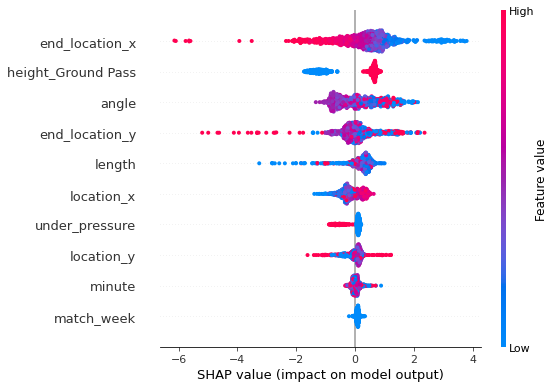

In [47]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)

# Quantify player's decision making 

In [48]:
X, y = prepare_train_test_data(match_passes=match_passes, features=new_features_mpa,split = False)

In [49]:
match_passes = match_passes.copy()
match_passes['prob'] = 0
match_passes['prob'] = model_final.predict_proba(X).copy()[:,1]
match_passes['target'] = y
match_passes['compared_to_avg'] = match_passes['target'] - match_passes['prob']

In [50]:
prob_per_zone_to_zone = match_passes.groupby(['field_zone_x','field_zone_y','end_field_zone_x','end_field_zone_y']).mean()['prob']
prob_per_zone_to_zone.mean()

0.8063352

### Risk definition

In [51]:
interception_prob = 1-prob_per_zone_to_zone
interception_prob

field_zone_x  field_zone_y  end_field_zone_x  end_field_zone_y
0             0             1                 0                   0.007224
                                              1                   0.589906
              1             1                 6                   0.083614
                            2                 1                   0.019910
                            8                 1                   0.012709
                                                                    ...   
49            31            48                29                  0.323108
                                              30                  0.054413
                            49                16                  0.206686
                                              17                  0.522184
                                              26                  0.018570
Name: prob, Length: 36851, dtype: float32

In [52]:
def risk(df):
    l = []
    for i in df.index:
        x = df.iloc[[i]]
        risk = interception_prob.loc[(x['field_zone_x'].values[0],x['field_zone_y'].values[0],x['end_field_zone_x'].values[0],x['end_field_zone_y'].values[0])]
        l.append(risk)
    df['risk'] = np.array(l)
    return df
match_passes = risk(match_passes)

### Valuing pass  
We extract the expected possession value from the website given in the base publication.

In [53]:
df_epv= pd.read_csv('EPV_data.csv',';',header= None)
df_epv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.0046,0.0046,0.0045,0.0046,0.0048,0.0051,0.0054,0.0057,0.0059,0.0062,0.0066,0.0068,0.0071,0.0072,0.0073,0.0077,0.0082,0.0086,0.0088,0.0092,0.0096,0.0100,0.0104,0.0110,0.0117,0.0123,0.0127,0.0131,0.0135,0.0142,0.0150,0.0160,0.0170,0.0181,0.0192,0.0208,0.0227,0.0244,0.0259,0.0276,0.0297,0.0313,0.0326,0.0341,0.0356,0.0365,0.0368,0.0388,0.0424,0.0443
1,0.0044,0.0044,0.0045,0.0046,0.0049,0.0052,0.0055,0.0058,0.0060,0.0062,0.0066,0.0069,0.0072,0.0074,0.0075,0.0079,0.0084,0.0087,0.0090,0.0093,0.0097,0.0102,0.0106,0.0112,0.0118,0.0123,0.0128,0.0132,0.0136,0.0143,0.0152,0.0162,0.0171,0.0183,0.0196,0.0211,0.0229,0.0246,0.0261,0.0278,0.0298,0.0314,0.0327,0.0342,0.0359,0.0368,0.0370,0.0388,0.0421,0.0437
2,0.0041,0.0042,0.0044,0.0047,0.0052,0.0056,0.0058,0.0060,0.0061,0.0063,0.0067,0.0070,0.0074,0.0076,0.0079,0.0083,0.0087,0.0090,0.0092,0.0095,0.0101,0.0106,0.0111,0.0115,0.0119,0.0124,0.0130,0.0135,0.0139,0.0146,0.0156,0.0165,0.0174,0.0186,0.0202,0.0218,0.0232,0.0248,0.0265,0.0283,0.0300,0.0315,0.0328,0.0345,0.0366,0.0376,0.0376,0.0388,0.0413,0.0425
3,0.0041,0.0042,0.0045,0.0049,0.0054,0.0058,0.0061,0.0062,0.0062,0.0064,0.0068,0.0072,0.0075,0.0079,0.0082,0.0085,0.0089,0.0092,0.0094,0.0098,0.0104,0.0109,0.0114,0.0118,0.0122,0.0126,0.0133,0.0138,0.0142,0.0150,0.0160,0.0170,0.0179,0.0192,0.0209,0.0224,0.0237,0.0252,0.0268,0.0284,0.0300,0.0316,0.0332,0.0351,0.0373,0.0386,0.0392,0.0400,0.0411,0.0417
4,0.0044,0.0045,0.0048,0.0052,0.0056,0.0060,0.0062,0.0064,0.0065,0.0067,0.0070,0.0073,0.0077,0.0080,0.0083,0.0087,0.0092,0.0095,0.0097,0.0101,0.0107,0.0113,0.0117,0.0121,0.0125,0.0129,0.0136,0.0141,0.0146,0.0153,0.0164,0.0175,0.0186,0.0200,0.0215,0.0230,0.0243,0.0256,0.0269,0.0282,0.0296,0.0315,0.0339,0.0361,0.0380,0.0400,0.0418,0.0424,0.0416,0.0412
5,0.0045,0.0047,0.0051,0.0054,0.0057,0.0060,0.0063,0.0066,0.0067,0.0069,0.0072,0.0075,0.0079,0.0082,0.0085,0.0089,0.0094,0.0098,0.0100,0.0104,0.0111,0.0116,0.0120,0.0124,0.0127,0.0131,0.0138,0.0144,0.0149,0.0157,0.0169,0.0180,0.0191,0.0204,0.0219,0.0234,0.0248,0.0261,0.0274,0.0287,0.0300,0.0323,0.0357,0.0382,0.0399,0.0421,0.0447,0.0452,0.0438,0.0430
6,0.0047,0.0049,0.0053,0.0056,0.0057,0.0060,0.0064,0.0067,0.0068,0.0070,0.0075,0.0078,0.0080,0.0083,0.0087,0.0091,0.0096,0.0100,0.0103,0.0108,0.0115,0.0119,0.0123,0.0125,0.0127,0.0132,0.0140,0.0147,0.0153,0.0162,0.0174,0.0184,0.0192,0.0204,0.0221,0.0237,0.0251,0.0267,0.0285,0.0299,0.0311,0.0340,0.0387,0.0416,0.0429,0.0449,0.0476,0.0486,0.0477,0.0473
7,0.0047,0.0050,0.0054,0.0057,0.0059,0.0062,0.0067,0.0070,0.0070,0.0072,0.0077,0.0080,0.0082,0.0085,0.0090,0.0094,0.0098,0.0102,0.0106,0.0111,0.0117,0.0122,0.0125,0.0128,0.0131,0.0136,0.0143,0.0151,0.0157,0.0166,0.0177,0.0187,0.0195,0.0207,0.0223,0.0238,0.0253,0.0273,0.0299,0.0321,0.0341,0.0373,0.0417,0.0446,0.0460,0.0489,0.0534,0.0546,0.0525,0.0514
8,0.0048,0.0050,0.0055,0.0059,0.0062,0.0066,0.0071,0.0074,0.0074,0.0076,0.0079,0.0082,0.0085,0.0088,0.0092,0.0095,0.0100,0.0104,0.0107,0.0112,0.0119,0.0124,0.0128,0.0132,0.0136,0.0142,0.0148,0.0155,0.0163,0.0171,0.0179,0.0188,0.0199,0.0211,0.0225,0.0238,0.0252,0.0278,0.0316,0.0353,0.0390,0.0421,0.0447,0.0471,0.0492,0.0541,0.0619,0.0633,0.0582,0.0556
9,0.0050,0.0052,0.0058,0.0062,0.0065,0.0069,0.0074,0.0077,0.0077,0.0078,0.0081,0.0084,0.0088,0.0091,0.0094,0.0097,0.0102,0.0106,0.0109,0.0114,0.0120,0.0125,0.0131,0.0136,0.0141,0.0146,0.0152,0.0158,0.0166,0.0173,0.0180,0.0189,0.0201,0.0214,0.0227,0.0243,0.0263,0.0293,0.0333,0.0373,0.0413,0.0452,0.0490,0.0540,0.0600,0.0655,0.0703,0.0702,0.0651,0.0626


In [54]:
def incremental_expected_possesion_value(df):
    l = []
    for i in df.index:
        x = df.iloc[[i]]
        epv = df_epv.loc[x['end_field_zone_y'].values[0],x['end_field_zone_x'].values[0]]-df_epv.loc[x['field_zone_y'].values[0],x['field_zone_x'].values[0]]
        l.append(epv)
    df['delta_EPV'] = np.array(l)
    return df
match_passes = incremental_expected_possesion_value(match_passes)
match_passes['successful_risk'] = match_passes['risk']*match_passes['target']
match_passes['successful_delta_EPV'] = match_passes['delta_EPV']*match_passes['target']

#### Quantify decsion making: player comparaison

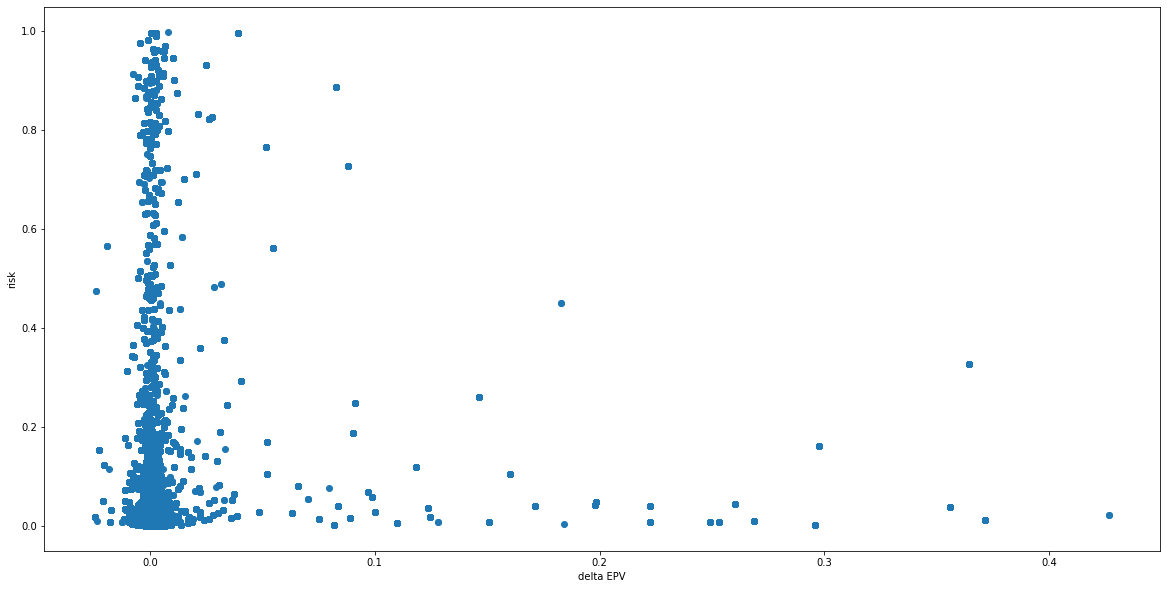

In [55]:
plt.figure(figsize=(20,10))
plt.scatter(match_passes['delta_EPV'],match_passes['risk'])
plt.xlabel('delta EPV')
plt.ylabel('risk')
plt.show()

Focus on Barca players with at least 300 passses done during the year.

In [56]:
barca_passes = match_passes[match_passes['team']=='Barcelona']
stats_player = barca_passes.groupby('player').agg({'under_pressure':'mean','length':'mean','home':'mean','n_related_events':'mean','prob':'mean','risk':'mean','delta_EPV':'mean','target':['mean','count','sum'],'successful_risk':'sum','successful_delta_EPV':'sum','compared_to_avg':'mean'})
stats_player = stats_player[stats_player[('target','count')]>300]
stats_player[('successful_risk','mean')] = stats_player[('successful_risk','sum')]/stats_player[('target','sum')]
stats_player[('successful_delta_EPV','mean')] = stats_player[('successful_delta_EPV','sum')]/stats_player[('target','sum')]
stats_player

under_pressure     length  \
                                                           mean       mean   
player                                                                       
Antoine Griezmann                                      0.167769  14.852956   
Clément Lenglet                                        0.073469  19.695199   
Francisco António Machado Mota de Castro Trincão       0.162319  14.005164   
Frenkie de Jong                                        0.129384  16.699396   
Gerard Piqué Bernabéu                                  0.073092  21.260783   
Jordi Alba Ramos                                       0.066833  16.286064   
Lionel Andrés Messi Cuccittini                         0.178766  16.782636   
Marc-André ter Stegen                                  0.091381  29.742415   
Miralem Pjanić                                         0.107143  16.353774   
Moriba Kourouma Kourouma                               0.210682  15.193955   
Ousmane Dembélé                                        0.129282  15.979813   
Pedro González López                                   0.168196  17.221337   
Philippe Coutinho Correia                              0.113772  16.082671   
Ricard Puig Martí                                      0.165563  16.916947   
Ronald Federico Araújo da Silva                        0.079118  21.515926   
Samuel Yves Umtiti                                     0.082405  18.875040   
Sergi Roberto Carnicer                                 0.086266  15.458507   
Sergino Dest                                           0.087748  13.931604   
Sergio Busquets i Burgos                               0.114943  18.128529   
Óscar Mingueza García                                  0.083164  17.428481   

                                                      home n_related_events  \
                                                      mean             mean   
player                                                                        
Antoine Griezmann                                 0.561157         1.281818   
Clément Lenglet                                   0.434467         1.171429   
Francisco António Machado Mota de Castro Trincão  0.713043         1.295652   
Frenkie de Jong                                   0.531177         1.233827   
Gerard Piqué Bernabéu                             0.559036         1.200000   
Jordi Alba Ramos                                  0.523588         1.201573   
Lionel Andrés Messi Cuccittini                    0.531683         1.308854   
Marc-André ter Stegen                             0.499481         1.176532   
Miralem Pjanić                                    0.373512         1.199405   
Moriba Kourouma Kourouma                          0.724036         1.296736   
Ousmane Dembélé                                   0.422099         1.259669   
Pedro González López                              0.516208         1.280734   
Philippe Coutinho Correia                         0.692615         1.201597   
Ricard Puig Martí                                 0.599338         1.238411   
Ronald Federico Araújo da Silva                   0.531777         1.184176   
Samuel Yves Umtiti                                0.652561         1.187082   
Sergi Roberto Carnicer                            0.520999         1.200908   
Sergino Dest                                      0.474338         1.187086   
Sergio Busquets i Burgos                          0.504558         1.217202   
Óscar Mingueza García                             0.535497         1.174442   

                                                      prob      risk  \
                                                      mean      mean   
player                                                                 
Antoine Griezmann                                 0.813834  0.164121   
Clément Lenglet                                   0.797314  0.152605   
Francisco António Machado Mota de Castro Trincão  0.776608  0.155039   
Fren

In [57]:
# Player with the best pass accuracy 
stats_player.sort_values(('target','mean'),ascending=False)

under_pressure     length  \
                                                           mean       mean   
player                                                                       
Francisco António Machado Mota de Castro Trincão       0.162319  14.005164   
Óscar Mingueza García                                  0.083164  17.428481   
Philippe Coutinho Correia                              0.113772  16.082671   
Sergio Busquets i Burgos                               0.114943  18.128529   
Clément Lenglet                                        0.073469  19.695199   
Gerard Piqué Bernabéu                                  0.073092  21.260783   
Miralem Pjanić                                         0.107143  16.353774   
Sergi Roberto Carnicer                                 0.086266  15.458507   
Frenkie de Jong                                        0.129384  16.699396   
Jordi Alba Ramos                                       0.066833  16.286064   
Marc-André ter Stegen                                  0.091381  29.742415   
Sergino Dest                                           0.087748  13.931604   
Lionel Andrés Messi Cuccittini                         0.178766  16.782636   
Samuel Yves Umtiti                                     0.082405  18.875040   
Pedro González López                                   0.168196  17.221337   
Antoine Griezmann                                      0.167769  14.852956   
Ronald Federico Araújo da Silva                        0.079118  21.515926   
Ousmane Dembélé                                        0.129282  15.979813   
Moriba Kourouma Kourouma                               0.210682  15.193955   
Ricard Puig Martí                                      0.165563  16.916947   

                                                      home n_related_events  \
                                                      mean             mean   
player                                                                        
Francisco António Machado Mota de Castro Trincão  0.713043         1.295652   
Óscar Mingueza García                             0.535497         1.174442   
Philippe Coutinho Correia                         0.692615         1.201597   
Sergio Busquets i Burgos                          0.504558         1.217202   
Clément Lenglet                                   0.434467         1.171429   
Gerard Piqué Bernabéu                             0.559036         1.200000   
Miralem Pjanić                                    0.373512         1.199405   
Sergi Roberto Carnicer                            0.520999         1.200908   
Frenkie de Jong                                   0.531177         1.233827   
Jordi Alba Ramos                                  0.523588         1.201573   
Marc-André ter Stegen                             0.499481         1.176532   
Sergino Dest                                      0.474338         1.187086   
Lionel Andrés Messi Cuccittini                    0.531683         1.308854   
Samuel Yves Umtiti                                0.652561         1.187082   
Pedro González López                              0.516208         1.280734   
Antoine Griezmann                                 0.561157         1.281818   
Ronald Federico Araújo da Silva                   0.531777         1.184176   
Ousmane Dembélé                                   0.422099         1.259669   
Moriba Kourouma Kourouma                          0.724036         1.296736   
Ricard Puig Martí                                 0.599338         1.238411   

                                                      prob      risk  \
                                                      mean      mean   
player                                                                 
Francisco António Machado Mota de Castro Trincão  0.776608  0.155039   
Óscar Mingueza García                             0.799207  0.148943   
Philippe Coutinho Correia                         0.801389  0.139992   
Serg

In [58]:
# Player with the highest incremental scoring probability thanks to his passes
stats_player.sort_values(('delta_EPV','mean'),ascending=False)

under_pressure     length  \
                                                           mean       mean   
player                                                                       
Philippe Coutinho Correia                              0.113772  16.082671   
Samuel Yves Umtiti                                     0.082405  18.875040   
Moriba Kourouma Kourouma                               0.210682  15.193955   
Sergino Dest                                           0.087748  13.931604   
Gerard Piqué Bernabéu                                  0.073092  21.260783   
Ronald Federico Araújo da Silva                        0.079118  21.515926   
Antoine Griezmann                                      0.167769  14.852956   
Sergi Roberto Carnicer                                 0.086266  15.458507   
Sergio Busquets i Burgos                               0.114943  18.128529   
Ricard Puig Martí                                      0.165563  16.916947   
Pedro González López                                   0.168196  17.221337   
Marc-André ter Stegen                                  0.091381  29.742415   
Lionel Andrés Messi Cuccittini                         0.178766  16.782636   
Jordi Alba Ramos                                       0.066833  16.286064   
Frenkie de Jong                                        0.129384  16.699396   
Clément Lenglet                                        0.073469  19.695199   
Miralem Pjanić                                         0.107143  16.353774   
Ousmane Dembélé                                        0.129282  15.979813   
Óscar Mingueza García                                  0.083164  17.428481   
Francisco António Machado Mota de Castro Trincão       0.162319  14.005164   

                                                      home n_related_events  \
                                                      mean             mean   
player                                                                        
Philippe Coutinho Correia                         0.692615         1.201597   
Samuel Yves Umtiti                                0.652561         1.187082   
Moriba Kourouma Kourouma                          0.724036         1.296736   
Sergino Dest                                      0.474338         1.187086   
Gerard Piqué Bernabéu                             0.559036         1.200000   
Ronald Federico Araújo da Silva                   0.531777         1.184176   
Antoine Griezmann                                 0.561157         1.281818   
Sergi Roberto Carnicer                            0.520999         1.200908   
Sergio Busquets i Burgos                          0.504558         1.217202   
Ricard Puig Martí                                 0.599338         1.238411   
Pedro González López                              0.516208         1.280734   
Marc-André ter Stegen                             0.499481         1.176532   
Lionel Andrés Messi Cuccittini                    0.531683         1.308854   
Jordi Alba Ramos                                  0.523588         1.201573   
Frenkie de Jong                                   0.531177         1.233827   
Clément Lenglet                                   0.434467         1.171429   
Miralem Pjanić                                    0.373512         1.199405   
Ousmane Dembélé                                   0.422099         1.259669   
Óscar Mingueza García                             0.535497         1.174442   
Francisco António Machado Mota de Castro Trincão  0.713043         1.295652   

                                                      prob      risk  \
                                                      mean      mean   
player                                                                 
Philippe Coutinho Correia                         0.801389  0.139992   
Samuel Yves Umtiti                                0.798473  0.158483   
Moriba Kourouma Kourouma                          0.795628  0.167086   
Serg

In [59]:
# Correlation by showing taking more risk reduces the pass accuracy
np.corrcoef(stats_player[('risk','mean')],stats_player[('target','mean')])

array([[ 1.        , -0.73519251],
       [-0.73519251,  1.        ]])

Text(0, 0.5, 'Pass Accuracy')

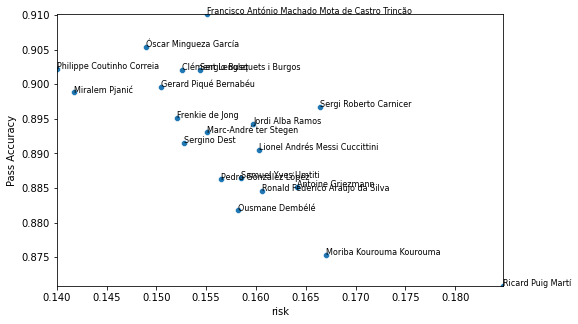

In [60]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=stats_player,x=stats_player[('risk','mean')],y=stats_player[('target','mean')])

for i in range(stats_player.shape[0]):
    plt.text(x=stats_player[('risk','mean')][i],y=stats_player[('target','mean')][i],s=stats_player.index[i], 
          fontdict=dict(color='black',size=8))
plt.xlim(stats_player[('risk','mean')].min(),stats_player[('risk','mean')].max())                #set x limit
plt.ylim(stats_player[('target','mean')].min(),stats_player[('target','mean')].max())
plt.xlabel('risk')
plt.ylabel('Pass Accuracy')

Text(0, 0.5, 'Delta EPV')

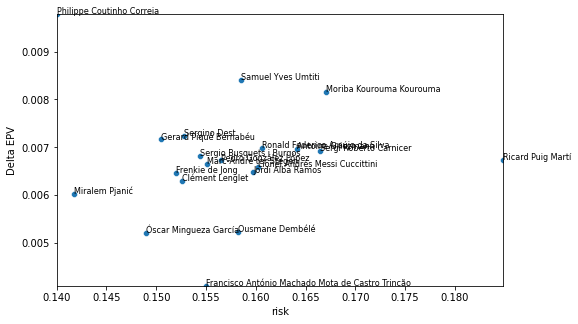

In [61]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=stats_player,x=stats_player[('risk','mean')],y=stats_player[('delta_EPV','mean')])

for i in range(stats_player.shape[0]):
    plt.text(x=stats_player[('risk','mean')][i],y=stats_player[('delta_EPV','mean')][i],s=stats_player.index[i], 
          fontdict=dict(color='black',size=8))
plt.xlim(stats_player[('risk','mean')].min(),stats_player[('risk','mean')].max())                #set x limit
plt.ylim(stats_player[('delta_EPV','mean')].min(),stats_player[('delta_EPV','mean')].max())
plt.xlabel('risk')
plt.ylabel('Delta EPV')

Text(0, 0.5, 'Successful Delta EPV')

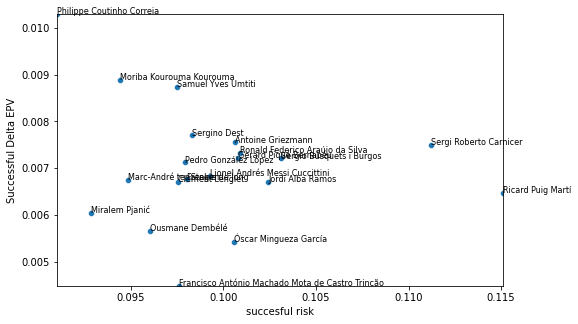

In [62]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=stats_player,x=stats_player[('successful_risk','mean')],y=stats_player[('successful_delta_EPV','mean')])

for i in range(stats_player.shape[0]):
    plt.text(x=stats_player[('successful_risk','mean')][i],y=stats_player[('successful_delta_EPV','mean')][i],s=stats_player.index[i], 
          fontdict=dict(color='black',size=8))
plt.xlim(stats_player[('successful_risk','mean')].min(),stats_player[('successful_risk','mean')].max())                #set x limit
plt.ylim(stats_player[('successful_delta_EPV','mean')].min(),stats_player[('successful_delta_EPV','mean')].max())
plt.xlabel('succesful risk')
plt.ylabel('Successful Delta EPV')